# Setup
Click the file icon on the left, then the upload file icon in the panel. Upload `implicit_hate_train.csv`, `implicit_hate_dev.csv`, and `implicit_hate_test.csv`

# Data loading

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import pandas as pd

In [3]:
folder = '/content/drive/MyDrive/CIS 530 project/'

In [4]:
import sys
sys.path.append(folder)

In [5]:

major_class_train_data = pd.read_csv(folder+"implicit_hate_train.csv")
major_class_dev_data = pd.read_csv(folder+"implicit_hate_dev.csv")
major_class_test_data = pd.read_csv(folder+"implicit_hate_test.csv")
print("major_class relevant keys: `post`, `class`")
print("  post: the tweet (str)")
print("  class: takes the values `explicit_hate`, `implicit_hate`, or `not_hate` (str)")

major_class relevant keys: `post`, `class`
  post: the tweet (str)
  class: takes the values `explicit_hate`, `implicit_hate`, or `not_hate` (str)


In [6]:
minor_class_train_data = major_class_train_data[major_class_train_data['implicit_class'].notnull()].reset_index(drop=True)
minor_class_dev_data = major_class_dev_data[major_class_dev_data['implicit_class'].notnull()].reset_index(drop=True)
minor_class_test_data = major_class_test_data[major_class_test_data['implicit_class'].notnull()].reset_index(drop=True)

print("minor_class relevant keys: `post`, `implicit_class`")
print("  post: the tweet (str)")
print("  implicit_class: takes the values `incitement`, `inferiority`, `irony`, `stereotypical`, `threatening`, or `white_grievance` (str)")

minor_class relevant keys: `post`, `implicit_class`
  post: the tweet (str)
  implicit_class: takes the values `incitement`, `inferiority`, `irony`, `stereotypical`, `threatening`, or `white_grievance` (str)


In [7]:
major_class_train_data['implicit_class']

0        irony
1        irony
2        irony
3        irony
4        irony
         ...  
16431      NaN
16432      NaN
16433      NaN
16434      NaN
16435      NaN
Name: implicit_class, Length: 16436, dtype: object

## Logistic regression classifier 


In [8]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 7.4 MB/s 
     |████████████████████████████████| 7.6 MB 63.1 MB/s 
     |████████████████████████████████| 182 kB 80.2 MB/s 


In [9]:
import numpy as np
import torch
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertModel, DistilBertTokenizer #change to model type you want, e.g. Bert or AlBert
from sklearn.metrics import accuracy_score, f1_score

In [10]:
#if needed, change the tokenizer here, this is used in the function to get CLS embeddings
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased") #not worried about uppercase vs lowercase
bert = DistilBertModel.from_pretrained("distilbert-base-uncased") #if needed, change model here

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [11]:
#used to make datasets and dataloaders.
#x = non-tokenized text
#y = labels
class ImplicitHateDataset(Dataset):
  def __init__(self,text,labels):
    self.x = text
    self.y = labels
  def __len__(self):
    return len(self.y)
  def __getitem__(self,idx):
    
    return self.x[idx],self.y[idx]

In [12]:
class LogisticClassifier():
  def __init__(self,tokenizer,bert_model,label_name):
    #label_name is class or implicit_class
    self.tokenizer = tokenizer
    self.bert = bert_model
    self.label_name = label_name
    self.logistic = LogisticRegression()

    if label_name == 'class':
      major_label_2_idx = {'not_hate' : 0, 'implicit_hate': 1, 'explicit_hate' : 2}
      major_idx_2_label = {0: 'not_hate', 1:'implicit_hate',2:'explicit_hate'}
      self.label2idx = np.vectorize(lambda x: major_label_2_idx[x])
      self.idx2label = np.vectorize(lambda x: major_idx_2_label[x])
      
    elif label_name == 'implicit_class':
      minor_label_2_idx = {'incitement':0,'inferiority':1,'irony':2,'stereotypical':3,'threatening':4,'white_grievance':5,'other':6}
      minor_idx_2_label = {0:'incitement', 1:'inferiority',2:'irony', 3:'stereotypical',4:'threatening',5:'white_grievance',6:'other'}
      self.label2idx = np.vectorize(lambda x: minor_label_2_idx[x])
      self.idx2label = np.vectorize(lambda x: minor_idx_2_label[x])


  def make_loader(self,data):
    #process the data into a dataloader so we don't tokenize everything at once and crash Colab
    #uses ImplicitHateDataset class from before
    #label_name is class or implicit_class
    post_list = data['post'].tolist()
    labels = data[self.label_name].tolist()
    dataset = ImplicitHateDataset(post_list,labels)
    loader = DataLoader(dataset,batch_size=8,shuffle=False)
    return loader, self.label2idx(np.array(labels))
  
  def make_embeddings_array(self,loader):
    """
    tokenizes each post in batches, and gets the embedding for its CLS token 
    (which is put in while we tokenize)
  
    Params:
    -------
    loader: dataloader containing the raw text and labels

    Returns:
    --------
    all_cls_embeddings: a 2D numpy array where each row is the CLS embedding of its corresponding post
    """
    all_cls_embeddings = None
    with torch.no_grad():
      for texts, labels in tqdm(loader):
        tokenized_texts = self.tokenizer(texts,padding=True,truncation=True, return_tensors='pt')
        embeddings = self.bert(**tokenized_texts).last_hidden_state
        cls_token_embeddings = torch.mean(embeddings[:,1:,:],1)
        if all_cls_embeddings is None:
          all_cls_embeddings = cls_token_embeddings.numpy()
        else:
          all_cls_embeddings = np.concatenate((all_cls_embeddings,cls_token_embeddings),axis=0)
        
    return all_cls_embeddings
  
  def train(self,data):
    loader, labels = self.make_loader(data)
    embeddings = self.make_embeddings_array(loader)
    self.logistic = LogisticRegression(multi_class = 'ovr').fit(embeddings,labels)

  def predict(self,data):
    loader,labels = self.make_loader(data)
    embeddings = self.make_embeddings_array(loader)
    predicted_class_idxs = self.logistic.predict(embeddings)
    return self.idx2label(predicted_class_idxs)
  

100%|██████████| 2055/2055 [14:43<00:00,  2.32it/s]
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

f1 score for class: 0.4281600010950429


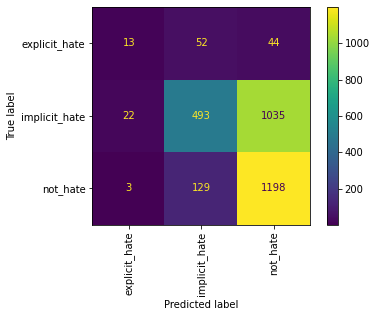

In [13]:
from evaluation import *
train_and_evaluate(LogisticClassifier(tokenizer,bert,"class"), major_class_train_data, major_class_test_data, "class")


100%|██████████| 618/618 [04:40<00:00,  2.20it/s]
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linea

f1 score for implicit_class: 0.5022462934184831


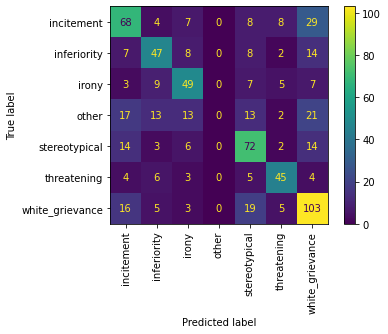

In [14]:
train_and_evaluate(LogisticClassifier(tokenizer,bert,"implicit_class"), minor_class_train_data, minor_class_test_data, "implicit_class")